In [43]:
import sys
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import when
from pyspark.sql.functions import udf

In [44]:
# fetch from local path otherwise fetch from the remote path (if remote kernel is being used)
try: 
    sys.path.append('../../scripts')
    import utils
    import spark
except:
    try:
        sys.path.append('./scripts')
        import utils
        import spark
    except:
        raise RuntimeError('Failed to import from both local and remote paths. Program terminated.')

In [45]:
spark = spark.setup_spark_session(app_name='Preprocess Tweets')

In [46]:
# Define the schema
schema = StructType([
    StructField('target', IntegerType(), True),
    StructField('text', StringType(), True),
])

In [47]:
df = spark.read.csv("hdfs://localhost:54310/user/datascience/data/processed/tweets_subset", header=False, schema=schema, sep="\t")

In [48]:
# check the values of the unique labels
df.groupBy('target').count().toPandas()

,target,count
0,4,800000
1,0,800000


### Map 1 for Positive instead of 4

In [49]:
# replace 4 with 1
change_target = when(df['target'] == 4, 1).otherwise(df['target'])
df = df.withColumn('target', change_target)

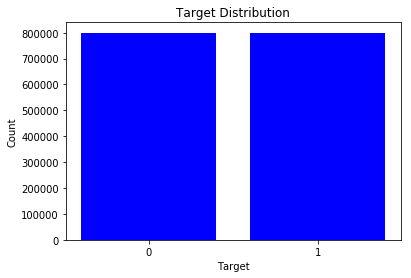

In [50]:
target_df = df.groupBy('target').count().toPandas()


plt.bar(target_df['target'], target_df['count'], color=['blue'])
plt.xticks([0, 1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

Check the null and empty values inside the tweets

In [51]:
null_values = df.filter(df['text'].isNull()).count()
empty_values = df.filter(df['text'] == '').count()

print(f'Number of null values: {null_values}')
print(f'Number of empty values: {empty_values}')

Number of null values: 0
Number of empty values: 0


In [52]:
# Perform the text preprocessing
def preprocess_text(tweet):
    words = utils.tokenize(tweet)
    tokens = []
    for word in words:
        # if the word is a stopword, skip it
        if utils.check_stopword(word): continue
        # Stem the word
        word = utils.stem(word)
        tokens.append(word)
    return " ".join(tokens)

In [53]:
before_df = df

preprocess_text_udf = udf(preprocess_text, "STRING")
df = df.withColumn('text', preprocess_text_udf(df['text']))

### Records before applying the preprocessing on the text

In [54]:
before_df.select('text').limit(2).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------+
|text                                                                                                               |
+-------------------------------------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
+-------------------------------------------------------------------------------------------------------------------+



### Records after applying the preprocessing on the text

In [55]:
# check the first two rows of the dataframe to see if the text has been preprocessed
df.select('text').limit(2).show(truncate=False)

+----------------------------------------------------------------------+
|text                                                                  |
+----------------------------------------------------------------------+
|awww that bummer shoulda got david carr third day                     |
|upset cant updat facebook text might cri result school today also blah|
+----------------------------------------------------------------------+



In [56]:
# Save the preprocessed data to the HDFS
df.write.csv(path='hdfs://localhost:54310/user/datascience/data/processed/tweets_preprocessed', mode='overwrite', header=False, sep="\t")

In [57]:
spark.stop()